**Description:** Risk Score Calculation with the best models for spam as well as opt-out

**Author:** Elena (Chaoran) Gou

**Last Update:** 08/06/2021

In [1]:
import pandas as pd
import numpy as np

import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

np.random.seed(2000)

/Users/egou/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
### Twilio brand colors: https://www.twilio.com/brand/resources/colorresources

# Primary Twilio brand colors
tw_red = '#F22F46'
night = '#001489'

# Secondary Twilio brand colors
blue = '#008CFF' # blue_50
green = '#36D576' # green_50
tangerine = '#F47C22' 
yellow = '#FFDD35' #yellow_40
purple = '#8C5BD8' #purple_50

# extended pallete
gray_30 = '#CACDD8' 
red_30 = '#f6b1b1' 
orange_30 = '#FAC2A0' 
green_30 = '#A2F6C3'
blue_30 = '#99CDFF'
purple_30 = '#C8AFF0'
gray_70 = '#4B5671'
red_70 = '#ad1111'
orange_70 = '#C35323'
green_70 = '#0E7C3A'
blue_70 = '#043CB5'
yellow_70 = '#C28E00'
purple_70 = '#5817BD'

teal = '#00BCD4'
mauve = '##DEA7E8'

charting_colors = [blue, green, tangerine, purple, yellow, tw_red, night, 
                   gray_30, red_30, blue_30, orange_30, green_30, purple_30,
                   gray_70, red_70, blue_70, orange_70, green_70, purple_70]

#'#FF5722', '#FA9950', '#FAD100', '#4CB04F', '#36D576', '#303F9F', '#2196F3', '#00BCD4', '#00E5FF', '#7B1FA2', '#7C4DFF', '#880E4F', '#DEA7E8', '#FF4081', '#9E9E9E'


# Twilio fonts
fonts = ['Helvetica Neue', 'Helvetica', 'Arial', 'sans-serif']

# set colors and fonts
sns.set_style('ticks', {'axes.linewidth': 2., 'font.sans-serif': fonts, 'font.family': 'Helvetica Neue'})
plt.rc('figure', figsize=(16, 10))
sns.set_context('poster', font_scale=1.0)
sns.set_palette(charting_colors)

### Data Read-in

In [3]:
account = pd.read_csv('feature_engineered_May.csv')
account.head()

,attempted,account_sid,delivered,optouts,_7726,unreachable,_30007,_30008,_21610,aup,...,friendly_name,default_name,optout_perc,_7726_perc,_30008_perc,_30007_perc,_21610_perc,unreachable_perc,aup_perc,fraud_perc
0,291830197,AC0c4da9c0a8c20ea8890c2ca186768bed,279827613.0,0.0,383.0,10232167,677429,671412,3538,0.0,...,us-east-1,0.0,0.000000,0.000001,0.002301,0.002321,0.000012,0.035062,0.0,0.0
1,770805,ACbdccf1d7b857189e72fdb51c878d34db,768406.0,0.0,0.0,1674,0,725,0,0.0,...,Samsung,0.0,0.000000,0.000000,0.000941,0.000000,0.000000,0.002172,0.0,0.0
2,92827,AC21e3df471603c934315eb61694a18ab2,90908.0,1.0,0.0,935,0,984,0,0.0,...,j.teichert@vivenu.com's Account,0.0,0.000011,0.000000,0.010600,0.000000,0.000000,0.010073,0.0,0.0
3,4682,AC4be872f5cb700cf41676089db563bbc9,4518.0,0.0,0.0,158,3,2,0,0.0,...,Meevo M2NA0_ T10713-Tenant: 45206,0.0,0.000000,0.000000,0.000427,0.000641,0.000000,0.033746,0.0,0.0
4,25605,AC4cac4fec76a9decc2838641318025fa6,22138.0,327.0,3.0,3432,9,26,0,0.0,...,k.morrisonhealthadvisor@gmail.com,0.0,0.014771,0.000136,0.001015,0.000351,0.000000,0.134036,0.0,0.0


In [4]:
june = pd.read_csv('feature_engineered_June.csv')
june.head()

,attempted,account_sid,delivered,optouts,_7726,cannabis,unreachable,_30007,_30008,_21610,...,_30008_perc,_30007_perc,_21610_perc,unreachable_perc,aup_perc,fraud_perc,age,parent,isv,fam_size
0,26038,AC9f3116fcac59b5b68a451cba28f5a731,23407.0,1354.0,1.0,0,15,0,2616,0,...,0.100469,0.000000,0.000000,0.000576,0.0,0.0,5,1,1,682
1,536793,AC06ea2a0e2f80d342b45f46e42571dd02,504624.0,479.0,0.0,0,31670,183,316,0,...,0.000589,0.000341,0.000000,0.058999,0.0,0.0,68,0,0,3
2,2278,AC9d6d9155f700898c3f4fb05c4e90188b,2240.0,0.0,0.0,0,4,0,27,0,...,0.011853,0.000000,0.000000,0.001756,0.0,0.0,31,0,0,1
3,22281,ACac15107fc288db00551d7d26bc4cc764,19295.0,132.0,0.0,0,1191,0,266,1475,...,0.011938,0.000000,0.066200,0.053454,0.0,0.0,68,0,0,7
4,550054,AC55880b122abfcb40df3510b02f02ed9e,521606.0,0.0,0.0,0,27300,1,582,142,...,0.001058,0.000002,0.000258,0.049631,0.0,0.0,20,1,1,82


### Risk Score Calculation

In [5]:
feature_perc = ['age','isv','parent','unreachable_perc',
       '_30007_perc', '_21610_perc', '_30008_perc', 
       'aup_perc','fraud_perc','cannabis','fam_size', 'default_name']

#train test split
train, test = train_test_split(account, test_size=0.3)
x_train = train[feature_perc]
y_train = train['_7726_perc']
x_test = test[feature_perc]
y_test = test['_7726_perc']

#generate prediction data
X=june[feature_perc]
y=june['_7726_perc']

#Generate values to calculate mean RMSE
y_bar = [y.mean()]*len(y)
train_bar = [y_train.mean()]*len(y_train)
test_bar = [y_test.mean()]*len(y_test)

### Make predictions with best models

In [6]:
#7726 % - Boosting
model = GradientBoostingRegressor(loss='lad',max_depth=6,n_estimators=70)
model.fit(x_train,y_train)
june['_7726_predict'] = model.predict(X)

In [7]:
#opt-out % - Decision Tree
y_train = train['optout_perc']
y_test = test['optout_perc']
y=june['optout_perc']
model = tree.DecisionTreeRegressor(max_depth=7,random_state=0)
model.fit(x_train,y_train)
june['_optout_predict'] = model.predict(X)

In [180]:
june.sort_values(by='_optout_predict',ascending=False)[['account_sid','optout_perc','_optout_predict']].head(20)

,account_sid,optout_perc,_optout_predict
41230,ACf3150984e0830c6ce7bd40a36761a3b8,0.007576,0.500000
66939,AC18908b6026b4c2aa0f2cec5b902eeb42,0.500000,0.333333
62377,ACd45b8fd7faae9b3cfdfc9ce043082c2c,0.000000,0.163462
77317,AC3ef2f7f2af66cf5ac8fc560b474d2e3c,0.000642,0.163462
39090,AC72cd3290fd6de946a25f4260e43dd03c,0.187774,0.162613
47882,AC165eef55c1ebe29c850987d9283eb069,0.005236,0.148148
25108,AC14989656923108dbffbca1a5d12ef7ca,0.018966,0.148148
9233,ACe64d8ed290060b70596296ba751b7ab5,0.011321,0.148148
61773,ACc77da5563c51331fde2cc63551579a74,0.021505,0.148148
37559,AC4b21c4d22f6919950d930e6dc4c9b8e7,0.069461,0.144394


In [72]:
june['optout_predict'].describe()

count    81085.000000
mean         0.005547
std          0.010493
min          0.000000
25%          0.000330
50%          0.001525
75%          0.005804
max          0.390282
Name: optout_predict, dtype: float64

In [73]:
#Assign different weights to spam and opt-out to generate risk scores
with pd.ExcelWriter('risk_score_0805.xlsx') as writer:  
    for i in range(10):
        wt1 = i*0.1
        wt2 = 1-wt1
        risk = 'risk_score' + str(round(wt1,1))
        june[risk] = wt1*june['_7726_predict'] + wt2*june['optout_predict']
        weight = str(round(wt1,1)) + ' 7726%, ' + str(round(wt2,1)) + ' optout%'
        print(weight)
        df = june.sort_values(by=risk,ascending=False)[['account_sid','_7726_perc','optout_perc',risk]].head(20)
        print(df)
        print(' ')
        df.to_excel(writer, sheet_name=str(weight))

0.0 7726%, 1.0 optout%
                              account_sid  _7726_perc  optout_perc  \
48831  AC6047438797798f94e68720c01c15daed    0.000000     0.334293   
4095   ACbe0c12d74726369ba176f65a66d6cbfb    0.000000     0.000022   
25576  ACf645cac20b4bb372844e77cb7ce71e93    0.000000     0.000000   
1485   AC271c169273f8d3ff82cd7560d30c0907    0.000000     0.000000   
75757  AC5022e3948e97280f8cdcd2a96ccaf192    0.000000     0.000107   
24853  AC50209036fe9be99006c7f3036d4e12f1    0.000000     0.001340   
44356  AC12e39d5303de6016a55de7310e13cc76    0.000000     0.000335   
11114  AC5a1d87336b64235ab0e5feb58899a2f5    0.000000     0.001805   
36627  AC5de0bcfce37bda3b996193b07f5a12f2    0.000000     0.000000   
6824   AC379f44d6c793aead3c757a1c8b1efab9    0.000000     0.176433   
35428  ACe97fdff3a7021c9ef4baf3c01e2ff4b3    0.000000     0.004857   
48978  AC5e7e4ab31fa2ef267d6392c14171c7ed    0.000000     0.035821   
18032  ACa1929278360ee84cf06244aebd44d711    0.001435     0.195600 

                              account_sid  _7726_perc  optout_perc  \
48831  AC6047438797798f94e68720c01c15daed    0.000000     0.334293   
4095   ACbe0c12d74726369ba176f65a66d6cbfb    0.000000     0.000022   
25576  ACf645cac20b4bb372844e77cb7ce71e93    0.000000     0.000000   
1485   AC271c169273f8d3ff82cd7560d30c0907    0.000000     0.000000   
75757  AC5022e3948e97280f8cdcd2a96ccaf192    0.000000     0.000107   
24853  AC50209036fe9be99006c7f3036d4e12f1    0.000000     0.001340   
66128  ACbd42f4d73f51f99ae58f9bb67616541a    0.000000     0.119764   
53585  AC3e0095b63a60b50667f80c7a68aaf3e4    0.000000     0.108145   
17374  ACb0d720a00170b7c70a1eaef72465d7a3    0.000000     0.055473   
41445  AC302286cf04f86c0e2c784409c5983106    0.000000     0.071491   
44356  AC12e39d5303de6016a55de7310e13cc76    0.000000     0.000335   
54555  ACc26d00961f728826b3f5543fbb8d4fed    0.002596     0.094095   
26209  AC819b3f06293b2d9f24447d57dfe223dd    0.000000     0.094308   
73043  AC2dcb74f2007

In [86]:
june[col].quantile(0.85)

_7726_perc        0.000000
optout_perc       0.008102
_7726_predict     0.004172
optout_predict    0.011343
risk_score0.0     0.011343
risk_score0.1     0.010691
risk_score0.2     0.010083
risk_score0.3     0.009470
risk_score0.4     0.008817
risk_score0.5     0.008114
risk_score0.6     0.007385
risk_score0.7     0.006600
risk_score0.8     0.005776
risk_score0.9     0.005007
Name: 0.85, dtype: float64

In [87]:
june.sort_values(by='risk_score0.0',ascending=False)[['account_sid','_7726_perc','optout_perc','risk_score0.0']].head(10)

,account_sid,_7726_perc,optout_perc,risk_score0.0
48831,AC6047438797798f94e68720c01c15daed,0.0,0.334293,0.390282
4095,ACbe0c12d74726369ba176f65a66d6cbfb,0.0,0.000022,0.376926
25576,ACf645cac20b4bb372844e77cb7ce71e93,0.0,0.000000,0.283530
1485,AC271c169273f8d3ff82cd7560d30c0907,0.0,0.000000,0.280724
75757,AC5022e3948e97280f8cdcd2a96ccaf192,0.0,0.000107,0.276300
24853,AC50209036fe9be99006c7f3036d4e12f1,0.0,0.001340,0.230528
44356,AC12e39d5303de6016a55de7310e13cc76,0.0,0.000335,0.171310
11114,AC5a1d87336b64235ab0e5feb58899a2f5,0.0,0.001805,0.162837
36627,AC5de0bcfce37bda3b996193b07f5a12f2,0.0,0.000000,0.158184
6824,AC379f44d6c793aead3c757a1c8b1efab9,0.0,0.176433,0.141128


In [185]:
#multiply risk % by 100 to generate risk scores
june['risk']=100*june['_optout_predict']

Text(0.5, 1.0, 'Risk Score Distribution\n')

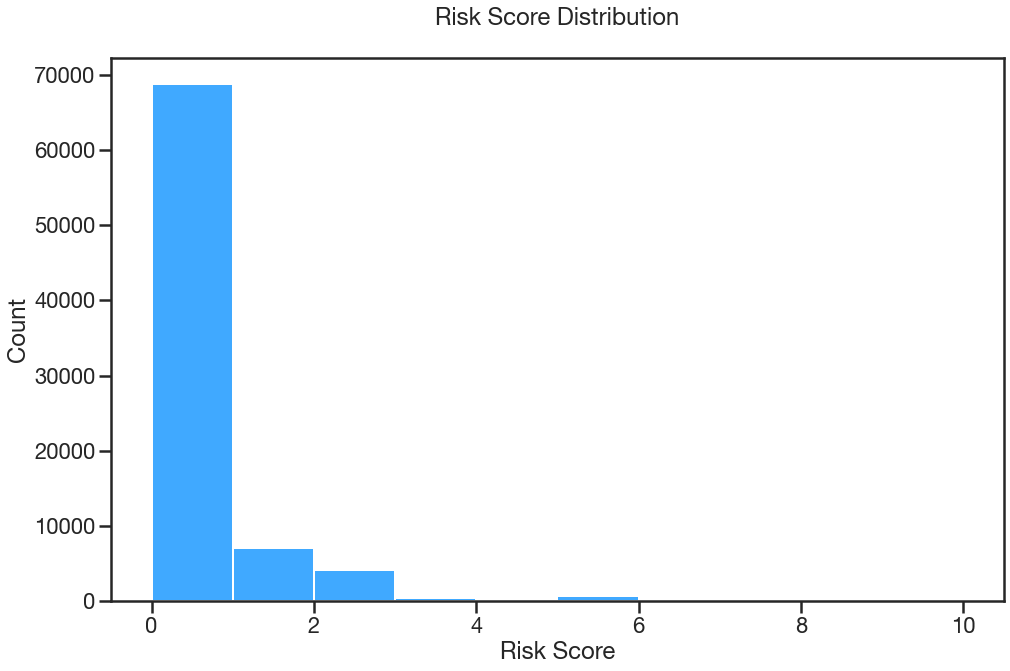

In [188]:
#Examine risk score distribution
sns.histplot(data=june,x='risk',bins=10,binrange=[0.0,10])
plt.xlabel("Risk Score")
plt.title('Risk Score Distribution\n')

In [189]:
june['risk'].describe() #85% threshold 1

count    81085.000000
mean         0.532119
std          0.844483
min          0.000000
25%          0.114764
50%          0.267026
75%          0.574685
max         50.000000
Name: risk, dtype: float64

In [192]:
#only 13 accounts have a risk score > 10 --> round down to 10
june[june['risk']>10].count()['_7726'] 

13

#### Geometric Mean

In [193]:
june['score_sqrt'] = np.sqrt(june['_7726_perc']*june['optout_perc'])

In [194]:
june.sort_values(by='score_sqrt',ascending=False)[['account_sid','_7726_perc','optout_perc','score_sqrt']].head(10)

,account_sid,_7726_perc,optout_perc,score_sqrt
68347,AC07c0269187a7eb3c6f4a08d9b9765f86,0.002219,0.332889,0.027180
21845,AC48710539ef56a7c5ff638c12e42a1c40,0.001942,0.201942,0.019802
7300,ACd4faec28d901f27379341beebf06fe1c,0.006211,0.049689,0.017568
11754,ACa8b0a65c3d02508b152be7d50f50a54b,0.001669,0.183259,0.017486
67524,ACfd93e5a3a06d37f1ac11b627ece57d7d,0.002632,0.108772,0.016919
18032,ACa1929278360ee84cf06244aebd44d711,0.001435,0.195600,0.016752
52356,ACfcb3fa7504f0cb1de291ef14e3c2e71d,0.001423,0.181759,0.016083
21011,AC3f29a72c85d45c7a519dc121cfc8b907,0.002418,0.106409,0.016042
54555,ACc26d00961f728826b3f5543fbb8d4fed,0.002596,0.094095,0.015628
54004,AC1aca0114016c3dccfd57850828491915,0.001403,0.166959,0.015305


In [196]:
june['score_sqrt_plus'] = np.sqrt((june['_7726_perc']+1)*june['optout_perc'])
june.sort_values(by='score_sqrt_plus',ascending=False)[['account_sid','_7726_perc','optout_perc','score_sqrt_plus']].head(10)

,account_sid,_7726_perc,optout_perc,score_sqrt_plus
30459,AC991f3f103f6a5f608278c1e283f139a1,0.000000,0.504940,0.710591
66939,AC18908b6026b4c2aa0f2cec5b902eeb42,0.000000,0.500000,0.707107
53163,AC61654e9d6f8240719b1d572d3abc4815,0.000000,0.362637,0.602194
12329,AC2253a591fbb80f622b788fe3759ffe59,0.000164,0.345330,0.587696
48831,AC6047438797798f94e68720c01c15daed,0.000000,0.334293,0.578181
68347,AC07c0269187a7eb3c6f4a08d9b9765f86,0.002219,0.332889,0.577606
49329,AC0c385c3ebe88de5d92ab368e21cb294a,0.000000,0.258291,0.508224
63390,AC8a29681ee833d5471b53662a36d2cee3,0.000000,0.234753,0.484513
7510,ACb99730fc9335bcba6ec19dd2a017a0fa,0.000225,0.232310,0.482039
32881,ACa9faec8f24d3ff3f4f62c4a9b2231503,0.000000,0.232120,0.481789
